[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IsmailAkram/Qiskit_Project_Ismail_Akram/blob/main/Qiskit_Project_Ismail_Akram.ipynb)

# Ismail Akram Qiskit Project
## PHYS 315 Quantum Computing Professor Cottrell
## Deutsch-Jozsa Quantum Circuit

In [1]:
# Importing Packages
import numpy as np # for arrays
import math as m # for things like ln, e, sqrt(), and so on

from qiskit import * # import everything, mainly funcationality like QuantimCircuit() and IBMQ, and Aer
# from qiskit.providers.ibmq import least_busy
# from qiskit import QuantumCircuit, transpile # instructions for the Quantum system. It holds all quantum operations.
# from qiskit.providers.aer import QasmSimulator # Aer higher performance circuit simulator

from qiskit.visualization import * # import everything, block spheres graphs, bar graphs for measurements
# from qiskit.visualization import plot_histogram # generates histograms

S_simulator = Aer.backends(name='statevector_simulator')[0] # allows simulation of states
M_simulator = Aer.backends(name='qasm_simulator')[0] # allows simulation of measurements

We'll implement the Deutsch-Jozsa algorithm for an n=3 bit function, and test for both constant and balanced oracles.

### Costant Oracle
Setting size of input register and creating a constant oracle.

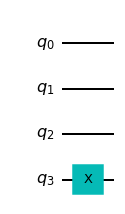

In [2]:
# setting length of n-bit input string
n = 3
const_oracle = QuantumCircuit(n+1)

# setting the output qubit to be 0 or 1 since input has no effect
output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)
    
const_oracle.draw('mpl')

### Balanced Oracle
Creating a balanced oracle by performing CNOT operations with each input qubit as the control and the output bit as the target.

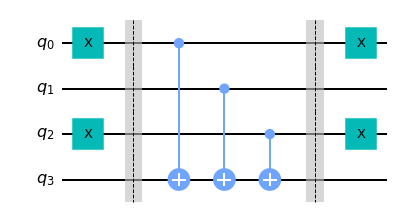

In [3]:
# we can create a balanced oracle by using CNOT with easch input qubit as a control and have the output as the target
# We can vary the input states that output a 0 or 1 by wrapping some of the controls with X-gates
balanced_oracle = QuantumCircuit(n+1)
b_str = "101" # dictates which controls to wrap


# placing aforementioned X-gates
# if the corresponding digit is 1, then place an X-gate, else do nothing
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Barrier as divider (highlighted in grey)
balanced_oracle.barrier()

# Then we apply our CNOT gates using each input qubit as a control and output as a target
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

# Another barrier
balanced_oracle.barrier()

# And then wrap with X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Display oracle
balanced_oracle.draw('mpl')

Now that we have our constructed balanced oracle, we must test if the Deutsch-Josza algorithm can solve it!

# Execution of the full algorithm
Putting everything together.

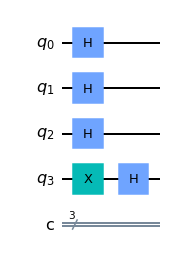

In [4]:
# initizaling input qubits as |+> and output qubit as |->
dj_circuit = QuantumCircuit(n+1, n)

# Applying H-gates (for our input qubits)
for qubit in range(n):
    dj_circuit.h(qubit)

# Placing (ouput) qubit in the state |->
dj_circuit.x(n)
dj_circuit.h(n)

dj_circuit.draw('mpl')

Building upon this, we apply the previously made balanced oracle.

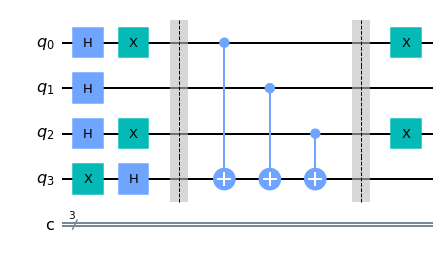

In [5]:
# Now to compose oracle on the dj_circuit
dj_circuit = QuantumCircuit(n+1, n)

# Applying H-gates (for our input qubits)
for qubit in range(n):
    dj_circuit.h(qubit)

# Placing (ouput) qubit in the state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Composing oracle
dj_circuit.compose(balanced_oracle, inplace = True) # basically "dj_circuit += balanced_oracle" but must use the compose function and pass Boolean as "True"
dj_circuit.draw('mpl')

Perfomring H-gates on our n=3 input qubit, and then measuring.

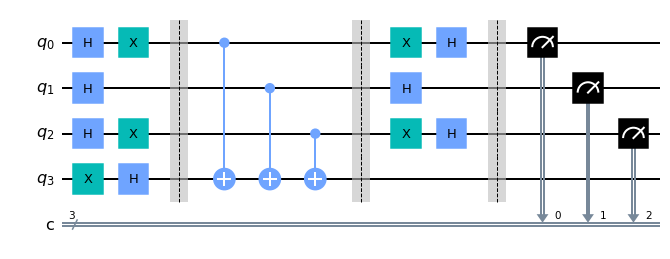

In [6]:
# Fianlly, adding Hadamard and then measuring
dj_circuit = QuantumCircuit(n+1, n)

# Applying H-gates (for our input qubits)
for qubit in range(n):
    dj_circuit.h(qubit)

# Placing (ouput) qubit in the state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit.compose(balanced_oracle, inplace = True) # basically dj_circuit += balanced_oracle but must use the compose function and pass Boolean as "True"

# Repeating H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measuring
for i in range(n):
    dj_circuit.measure(i, i)

dj_circuit.draw('mpl')

Analyzing output

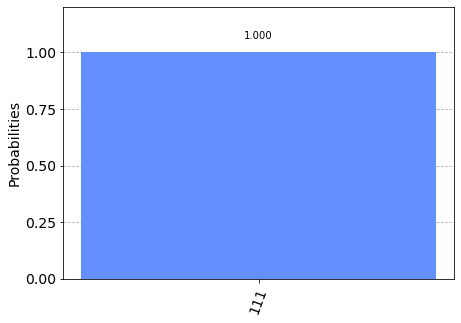

In [7]:
# Using local simulator
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(dj_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

Conclusion: we have a 0% chance of measuring 000. Which means the function is indeed balanced!

### Generalizing Circuits
To account for generalization, we create a generalized function for Deutsch-Josza oracles. The function will then transform those oracles into our desired quantum gates. The function will take in two inputs: case (balanced or constant) and n (the size of the input register).

In [8]:
# Creating a generalized function that generates Deutsch-Josza oracles and transforms them into quantum gates. It will take:
# <case> ... balanced/constant 
# <n> ... size of input register

def dj_oracle(case, n):
    
    # QuantumCircuit object (to return)
    # size: n+1 qubits (n inputs + 1 output)
    oracle_qc = QuantumCircuit(n+1)
    
    # When oracle is balanced
    if case == "balanced":
        
        # Generating a randint for which CNOTs to wrap in X-gates, b = binary string:
        b = np.random.randint(1,2**n)
        
        # formatting and padding string b with zeros
        b_str = format(b, '0'+str(n)+'b')
        
        # Placing first X-gates. Each digit in our binary string corresponds to a qubit:
        # if the digit is 1, then applying X-gate to that digit
        # else, do nothing
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        
        # CNOT gates for each qubit, using target output qubit
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        
        # Placing final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # When oracle is constant
    if case == "constant":
        
        # Using randint to detemrine the fixed output of the oracle (always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    # Transforming into gates
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = " Oracle" # Display
    return oracle_gate

Function that takes in the above function and applies Deutsch-Josza algorithm.

In [9]:
# Function that takes in above oracle gate as input and applys Deutsch-Josza algorithm

def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    
    # Output qubit
    dj_circuit.x(n)
    dj_circuit.h(n)
    
    # Input register
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    # Appending aforementioned oracle gate on our circuit:
    dj_circuit.append(oracle, range(n+1))
    
    # Performing H-gates (again) and measuring:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

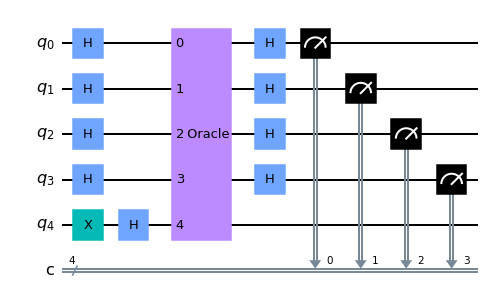

In [10]:
# Testing
n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw('mpl')

Now let's see the results of executing this circuit.

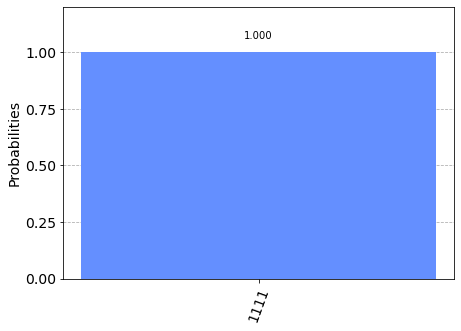

In [11]:
# Plotting
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
qobj = assemble(transpiled_dj_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

Conclusion: and like before, we have a 0% chance of measuring 0000. Function is balanced and works!

# Experimenting with a real device
Now to apply on a real IBM device.

In [12]:
# Loading IBMQ accounts and using the least busy backend device (with >= (n+1) qubits)
from qiskit.providers.ibmq import least_busy

IBMQ.save_account('6b793b8fa16948141373c700d6c3891cb0e0f07f7fec6f4c83595d664cc49cd3424c50fe920607f4a97dfdfeb0d60102e99ebf580a83b5128befeabf9f7a6ea7')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

configrc.store_credentials:WARNING:2022-06-07 22:36:38,589: Credentials already present. Set overwrite=True to overwrite.


least busy backend:  ibmq_lima


In [13]:
# Runing our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

transpiled_dj_circuit = transpile(dj_circuit, backend, optimization_level=3)
job = backend.run(transpiled_dj_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


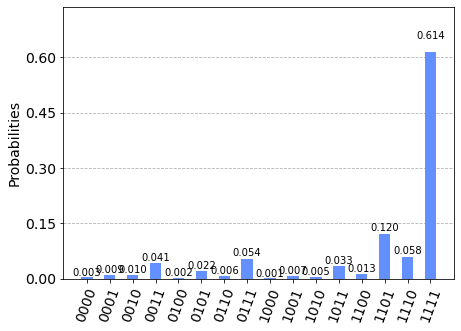

In [14]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

Conclusion: interestingly, this time the most likely result is 1111. We don't have a single block histogram like before. This is due to the other results being errors in the quantum computation (i.e. theory vs reality of execution).

Even so, we know this function is balanced.